In [83]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import plotly.express as px
import ast
from geopy.geocoders import Nominatim

In [20]:
df=pd.read_csv('items.csv')

In [4]:
df.columns

Index(['series', 'identifier_swisscollections', 'subject_form',
       'library_call_number', 'resource_type',
       'date_of_publication_or_production_standardised', 'place_standardised',
       'physical_description', 'language', 'title'],
      dtype='object')

In [3]:
df.head()

,series,identifier_swisscollections,subject_form,library_call_number,resource_type,date_of_publication_or_production_standardised,place_standardised,physical_description,language,title
0,"['Autographensammlung Karl Geigy-Hagenbach. I,...",991170522224305501,"['Autograf', 'Handschrift', 'Briefsammlung']","Basel, UB, UBH Autogr Geigy-Hagenbach 1127","['Brief', 'Autograph', 'Archivmaterial / Archi...",18060815,"{'name': 'Kopenhagen', 'identifier': ['(DE-588...","['2 Bl. (2 S. beschrieben) ; 19,5 x 12,5 cm']",['Deutsch'],Brief an Breitkopf und Härtel
1,"['Autographensammlung Karl Geigy-Hagenbach. I,...",991170522224905501,"['Autograf', 'Handschrift', 'Briefsammlung']","Autographensammlung Geigy-Hagenbach, -","['Brief', 'Autograph', 'Archivmaterial / Archi...",17940115,"{'name': 'Zürich', 'identifier': ['(DE-588)406...","['2 Bl. (4 S. beschrieben) ; 22,5 x 19 cm']",['Deutsch'],Brief an [Gottlieb Hufeland]
2,"['Autographensammlung Karl Geigy-Hagenbach. I,...",991170522225205501,"['Autograf', 'Handschrift', 'Briefsammlung']","Basel, UB, UBH Autogr Geigy-Hagenbach 1121","['Brief', 'Autograph', 'Archivmaterial / Archi...",18070822,"{'name': 'Nürnberg', 'identifier': ['(DE-588)4...",['1 Bl. (2 S. beschrieben) ; 18 x 12 cm'],['Deutsch'],Brief an Hofrat
3,"['Autographensammlung Karl Geigy-Hagenbach. I,...",991170522227205501,"['Autograf', 'Handschrift', 'Briefsammlung']","Autographensammlung Geigy-Hagenbach, -","['Brief', 'Autograph', 'Archivmaterial / Archi...",17960601,"{'name': 'Mannheim', 'identifier': ['(DE-588)4...","['2 Bl. (1 S. beschrieben) ; 18,5 x 11,5 cm']",['Deutsch'],Brief an Unbekannt
4,"['Autographensammlung Karl Geigy-Hagenbach. I,...",991170522227605501,"['Autograf', 'Handschrift', 'Briefsammlung']","Autographensammlung Geigy-Hagenbach, -","['Brief', 'Autograph', 'Archivmaterial / Archi...",18061213,"{'name': 'Berlin', 'identifier': ['(DE-588)400...",['1 Bl. (2 S. beschrieben) ; 23 x 19 cm'],['Deutsch'],Brief an [Christian Gottlob] Voigt


In [84]:
import pandas as pd
import re

def find_date_of_publication(x):
    try:
        # Split the input by `/` or `-` to prioritize the first date segment
        segments = re.split(r'[/-]', x)
        for segment in segments:
            # Process each segment as a potential date
            segment = segment.strip()
            if len(segment) == 8:  # YYYYMMDD format
                try:
                    return pd.to_datetime(segment, format='%Y%m%d', errors='coerce').year
                except ValueError:
                    continue
            elif len(segment) == 4:  # Year
                return int(segment)

        # Check for year ranges like '1930-1972' and take the start year
        match_range = re.search(r'\b(\d{4})-(\d{4})\b', x)
        if match_range:
            return int(match_range.group(1))  # Return the first year in the range

        # If no valid date is found, fallback to extracting a 4-digit year
        match_year = re.search(r'\b(\d{4})\b', x)
        if match_year:
            return int(match_year.group(1))
         # Original logic for numeric-like processing
        
        result = ''.join(char for char in x if char.isdigit() or char in ['/', ',', '-'])
        if result[0] == '-':
            result = result[1:]

        if '/' in result:
            result = result.split('/')[0]
        if ',' in result:
            result = result.split(',')[0]
        if '-' in result:
            result = result.split('-')[0]

        if len(result) == 4:  # Year
            return int(result)
        if len(result) == 8:  # YYYYMMDD or DDMMYYYY
            try:
                return pd.to_datetime(result, format='%Y%m%d').year
            except ValueError:
                try:
                    return pd.to_datetime(result, format='%d%m%Y').year
                except ValueError:
                    return None
        else:
            return int(result[:4])  # Fallback to the first 4 digits if all else fails

    except Exception as e:
        print(f"Error processing: {x}, Exception: {e}")
        return None


In [85]:

x=find_date_of_publication('19950619/2001-01')
x


1995

In [86]:
df['found_date']=df.date_of_publication_or_production_standardised.apply(find_date_of_publication)

In [94]:
df=df[df['found_date']>=1000]

<Axes: xlabel='found_date', ylabel='Count'>

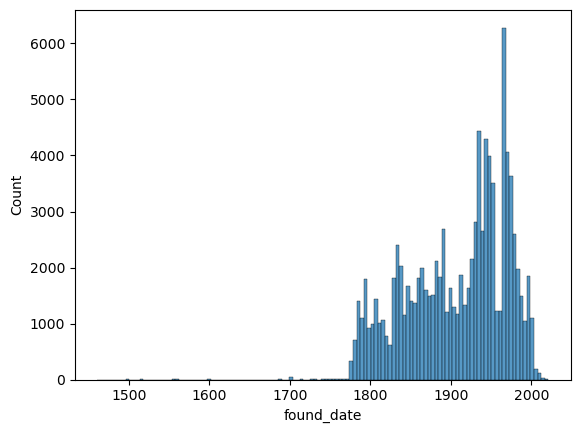

In [95]:
import seaborn as sns
sns.histplot(df['found_date'])

In [96]:
df['language'] = df['language'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
df['language'] = df['language'].str.split(',\s*')  # Split by commas with optional whitespace

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\348661910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['language'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\348661910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['language'].str.split(',\s*')  # Split by commas with optional whitespace


In [97]:
mapping_language={'In Kurzenberger-Mundart':'Deutsch','In Alter Häädler-Sprooch':'Deutsch','Vinzel':'Deutsch','Schweizerdeutsch (Alte Häädler Puuresproch)':'Deutsch','Ranzösisch':'Französisch','Osmanisch-Türkisch':'Türkisch','Schweizerdeutsch':'Deutsch','Notizen Vorwiegend Deutsch':'Deutsch','Notizen Deutsch':'Deutsch','Niederdeutsch':'Deutsch','Deutsch Oder Schweizerdeutsch':'Deutsch','Baseldeutsch':'Deutsch','English':'Englisch','England':'Englisch','Deusch':'Deutsch','Detusch':'Deutsch'  ,  "Franzsösisch": "Französisch",
    "Französich": "Französisch",
    "Franösisch": "Französisch",'French':'Französisch','German':'Deutsch','Lateinisch':'Latein','Titel: Deutsch':'Deutsch','Turkisch':'Türkisch','Urdu ?':'Urdu','deutsch':'Deutsch','französisch':'Französisch','Paris':'Französisch','Ger':'Deutsch','Russian':'Russisch','Handgeschriebenes Gedicht Schweizerdeutsch':'Deutsch','Einleitung Deutsch':'Deutsch','Haupttext Deutsch ; Unterschrift Aleksanderʺ In Alter Russischer Schrift':'Deutsch','Dialoge Schweizerdeutsch':'Deutsch','Deutschsprachiger Entwurf':'Deutsch','Italienische':'Italienisch','Nebst Latein':'Latein'}



In [98]:
# Function to split on "und" and replace with a list of words
def split_on_und(values):
    new_values=[]
    for value in values:
        
        value = ''.join([i for i in value if not i.isdigit()])
        
        
    # Remove extra spaces
        value = ' '.join(value.split())
        if 'Texte' in value:
            value=value.replace('Texte','')
            value=value.strip()
        if 'Text' in value:
            value=value.replace('Text','')
            value=value.strip()
        if ' und ' in value or ' Oder ' in value:
            new_list=value.split(' und ')
            for v in new_list:
                v=v.title().strip()
                if v in mapping_language:
                 
                    new_values.append(mapping_language[v.strip()].title())
                else:
       
                    new_values.append(v.title())
        else:
            if value.title() in mapping_language:
                
                new_values+=[mapping_language[value.title().strip()]]
            else:
                new_values+=[value.title()]
    return list(set(new_values))

In [99]:
df['corrected_lang']=df.language.apply(split_on_und)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\1937373853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['corrected_lang']=df.language.apply(split_on_und)


In [100]:

# Step 2: Flatten the list of lists and find unique values
unique_languages = set([lang for sublist in df['corrected_lang'] for lang in sublist])

len(unique_languages)

38

In [101]:
df['corrected_subject_form'] = df['subject_form'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
df['corrected_subject_form'] = df['corrected_subject_form'].str.split(',\s*')  # Split by commas with optional whitespace


df['corrected_resource_type'] = df['resource_type'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
df['corrected_resource_type'] = df['corrected_resource_type'].str.split(',\s*')  # Split by commas with optional whitespace

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\375413667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['corrected_subject_form'] = df['subject_form'].str.replace("[\[\]']", '', regex=True)  # Remove brackets and quotes
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\375413667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['corrected_subject_form'] = df['corrected_subject_form'].str.split(',\s*')  # Split by commas with optional whitespace
C:\Users\Yasaman\AppData\Local\Temp\ipykern

In [102]:

# Step 2: Flatten the list of lists and find unique values
unique_subjects = set([subj.strip() for sublist in df.corrected_subject_form for subj in sublist])

# Display the result as a sorted list
unique_subjects = sorted(unique_subjects)
len(unique_subjects)

49

In [103]:

# Step 2: Flatten the list of lists and find unique values
unique_resource_type= set([subj.strip() for sublist in df.corrected_resource_type for subj in sublist])
# Display the result as a sorted list
unique_resource_type = sorted(unique_resource_type)
len(unique_resource_type)

14

In [104]:
def get_city(x):
    if x:
        return x.split(',')[0]
    return None

In [105]:
df['library_city']=df.library_call_number.apply(get_city)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\2989506673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['library_city']=df.library_call_number.apply(get_city)


In [106]:
location_maps={'Autographensammlung Geigy-Hagenbach':'Basel','Bernoulli-Briefinventar':'Basel'}

In [107]:
df['library_city']=df.library_city.apply(lambda x: location_maps[x] if x in location_maps else x)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\22671486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['library_city']=df.library_city.apply(lambda x: location_maps[x] if x in location_maps else x)


In [108]:
latitudes = {
    'Basel': 47.5596,
    'Solothurn': 47.2088,
    'Trogen': 47.4084,
    'St. Gallen': 47.4239,
    'Zofingen': 47.2889,
    'Bern': 46.9481,
    'Luzern': 47.0502,
    'Aarau': 47.3925
}

longitudes = {
    'Basel': 7.5886,
    'Solothurn': 7.5323,
    'Trogen': 9.4622,
    'St. Gallen': 9.3748,
    'Zofingen': 7.9448,
    'Bern': 7.4474,
    'Luzern': 8.3093,
    'Aarau': 8.0443
}



df['location_library_latitude']=df.library_city.map(latitudes)
df['location_library_longitude']=df.library_city.map(longitudes)

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\2760264642.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location_library_latitude']=df.library_city.map(latitudes)
C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\2760264642.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location_library_longitude']=df.library_city.map(longitudes)


In [109]:
city_plot=df.groupby(['library_city','location_library_latitude','location_library_longitude'])['series'].count().reset_index().rename(columns={'series':'count'})

In [111]:
city_plot['squared_root']=np.sqrt(city_plot['count'])

In [112]:

# Create the map plot with circles sized by 'count'
fig = px.scatter_mapbox(
    city_plot, 
    lat="location_library_latitude", 
    lon="location_library_longitude", 
    size_max=50, 
    hover_name="library_city",
    size='squared_root',
    hover_data={"count": True,'squared_root':False},
    title="Records distribution by Library's location",
    mapbox_style="open-street-map",
    zoom=6,
    center={"lat": 46.85, "lon": 8.2}
)

fig.show()

In [113]:
# Convert the 'city_info' column from string to dictionary
df['place_standardised'] = df['place_standardised'].apply(ast.literal_eval)

# Optionally, extract the 'name' and 'identifier' fields into separate columns
df['city_info'] = df['place_standardised'].apply(lambda x: x['name'])
#df['identifier'] = df['city_info'].apply(lambda x: x['identifier'])

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\120731939.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Yasaman\AppData\Local\Temp\ipykernel_18628\120731939.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
from tqdm import tqdm
tqdm.pandas()

In [114]:
df_cities=pd.read_csv('worldcities.csv')

In [115]:
df=df.merge(df_cities[['city','lat','lng','country']], right_on='city',left_on='city_info', how='left')

In [57]:
# Define function to get latitude and longitude

def get_lat_long(city_name):
    try:
        geolocator = Nominatim(user_agent='myapplication')
        location = geolocator.geocode(city_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except: 
        print(city_name)
        return None, None
cities=df[df.city.isna()]['city_info'].unique()
city_mapping={city:get_lat_long(city) for city in tqdm(cities)}

St. Urban


München


Rodersdorf


Hanover (N.H.)


Koločep


Areuse


Tremezzo


Schäftlarn


Chiasso


Wahlen


Fontainemelon


Mariafeld


Friedenau


Aeschi bei Spiez


Düren-Gürzenich


Fontfroide


Villeret


San Domenico


Indianapolis, Ind.


Cambo-les-Bains


Thomery


Meina


Morschach


Egg-Dussnang


Iseltwald


Liwadija


Freiburg im Üechtland-Pérolles


Avila


Kfar Sin Kin (Palästina)


Cleveland, Ohio


Peckham


Sophienkoog


Wilno


Berlion


Wiesendangen


Mont Pelérin


Bismark (Altmark)


Eptingen


Kolpin


Wasen


Baden (Österreich)


Oppeln


Grafenwöhr


Altenbeuern


Cortina d'Ampezzo


Hamborn


Saint-Briac


Münden


Bärschwil


Sils/Segl Baselgia


Windischleuba


Weissenberg i.B.


Kohren


100%|██████████| 4194/4194 [1:19:56<00:00,  1.14s/it]


In [59]:
# Transforming data into a DataFrame
df_city_geocoded = pd.DataFrame.from_dict(city_mapping, orient='index', columns=['Latitude', 'Longitude'])
df_city_geocoded.reset_index(inplace=True)
df_city_geocoded.rename(columns={'index': 'City'}, inplace=True)

In [61]:
df_city_geocoded.to_csv('df_city_geocoded.csv')

In [125]:
df_city_geocoded=pd.read_csv('df_city_geocoded.csv')
del df_city_geocoded['Unnamed: 0']
df_city_geocoded.set_index('City', inplace=True)

In [127]:
city_mapping=df_city_geocoded.to_dict(orient='index')

In [150]:

# Apply function to the DataFrame column
df[['place_latitude', 'place_longitude']] = df['city_info'].progress_apply(lambda x: pd.Series(get_lat_long(x)))

AttributeError: 'Series' object has no attribute 'progress_apply'

In [134]:
for i, row in df[df.lat.isna()].iterrows():
    if pd.isna( row['lat']):
        df.at[i, 'lat']=city_mapping[df.at[0, 'city_info']]['Latitude']
    if pd.isna( row['lng']):
        df.at[i, 'lng']=city_mapping[df.at[0, 'city_info']]['Longitude']

In [141]:
df=df[~df.lng.isna()]

In [144]:
final_df=df[['series','identifier_swisscollections','library_call_number','physical_description','title','corrected_resource_type','corrected_subject_form','location_library_latitude','location_library_longitude','lat', 'lng']]

In [150]:
final_df.to_csv('final_df.csv', index=False)

In [106]:
city_df_plot=df.groupby(['city_info','lat', 'lng'])['series'].count().reset_index().rename(columns={'city_info':'city', 'series':'count'})

In [107]:
city_df_plot=city_df_plot.sort_values('lng', ascending=False).drop_duplicates(['city'],keep='first')

In [137]:
import plotly.express as px
import plotly.graph_objects as go

# Create the map plot with circles sized by 'count'
fig = px.scatter_mapbox(
    city_df_plot, 
    lat="lat", 
    lon="lng", 
    size_max=50, 
    hover_name="city",
    size='count',
    hover_data={"count": True},
    title="Records distribution by Piece's location",
    mapbox_style="open-street-map",
    zoom=2.7,
    center={"lat": 49, "lon": 10}
)



fig.show()


In [82]:
df[df['found_date'].isna()].sum()

series                                            ['Briefe an Josef Bernhard Altermatt; 16']['Br...
identifier_swisscollections                                                     5892200242918886519
subject_form                                      ['Handschrift', 'Briefsammlung', 'Autograf']['...
library_call_number                               Solothurn, ZB, ZBS S I 465/2/16Solothurn, ZB, ...
resource_type                                     ['Brief', 'Autograph', 'Archivmaterial / Dossi...
date_of_publication_or_production_standardised    17920512, 1792051418020210, 1806011517700603, ...
place_standardised                                {'name': 'Dornach', 'identifier': ['(DE-588)40...
physical_description                              ['1 Mappe']['1 Mappe']['1 Mappe']['1 Mappe']['...
language                                          ['Französisch']['Französisch']['Französisch'][...
title                                             2 Briefe an Josef Bernhard Altermatt23 Briefe ...


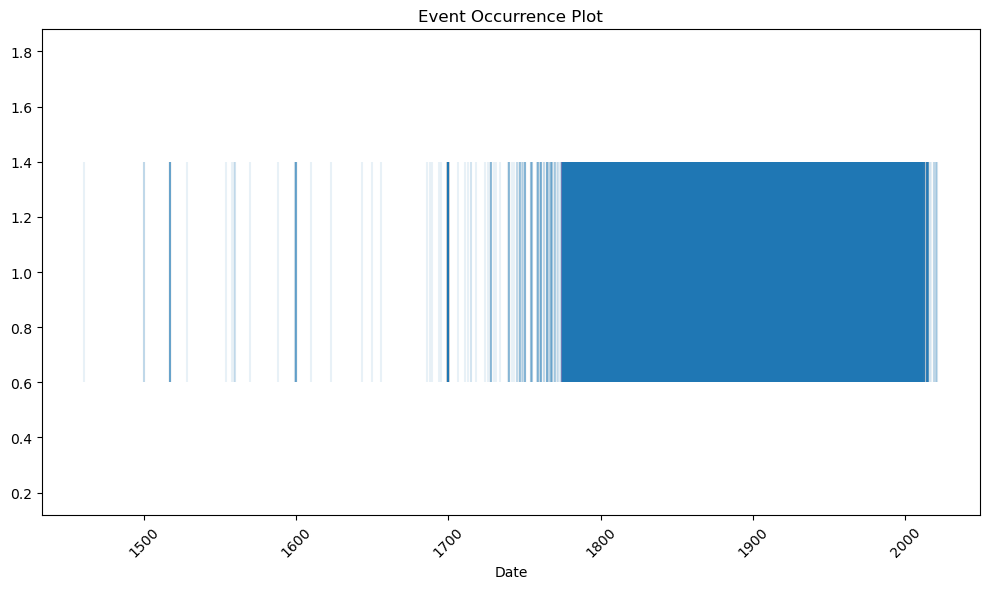

In [147]:
import matplotlib.pyplot as plt

# Preparing the data for eventplot (convert 'found_date' to timestamps if needed)
event_times = df['found_date']

# Plotting the events
plt.figure(figsize=(10, 6))
plt.eventplot(event_times, orientation='horizontal', lineoffsets=1, linelengths=0.8, alpha=0.1)

# Adding labels and title
plt.xlabel("Date")
plt.title("Event Occurrence Plot")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='found_date', ylabel='Count'>

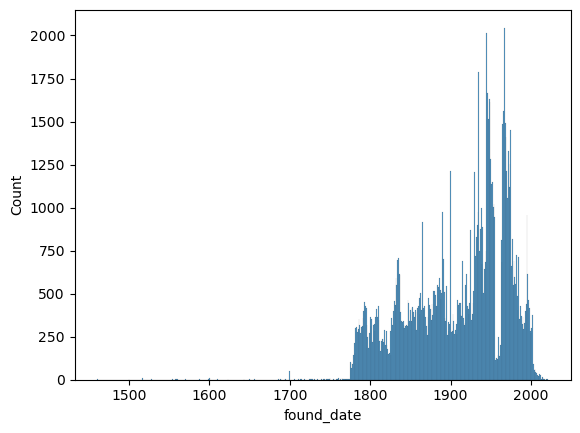

In [149]:
import seaborn as sns
sns.histplot(data =df, x='found_date', discrete=True)